In [ ]:
!pip install lightfm
!pip install optuna
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR = "/content/drive/MyDrive/rec/"

In [ ]:
d1 = pd.read_json(DATA_DIR + "rand1.json", lines=True)
d2 = pd.read_json(DATA_DIR + "rand2.json", lines=True)
light1 = pd.read_json(DATA_DIR + "light_huge1.json", lines=True)
light2 = pd.read_json(DATA_DIR + "light_huge2.json", lines=True)
sticky = pd.read_json(DATA_DIR + "sticky.json", lines=True)
context1 = pd.read_json(DATA_DIR + "context_1.json", lines=True)
context2 = pd.read_json(DATA_DIR + "context_2.json", lines=True)

In [ ]:
data = pd.concat([d1, d2, light1, light2, sticky, context1, context2], ignore_index=True, sort=False)
print(data.shape)
data = data.drop_duplicates(subset=["user", "track"])
print(data.shape)

(2607223, 8)
(2023150, 8)


In [ ]:
positives = data[data["time"] > 0.7].copy()
positives["test"] = np.random.random(len(positives)) >= 0.7

In [ ]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 5].index.values)

In [ ]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 5].index.values)

## Train LightFM

In [ ]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(300977, 122649)

In [ ]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [ ]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [ ]:
train_interactions.count_nonzero()/train_interactions.todense().size

0.002814201696532288

In [ ]:
def fit_model(
    epochs=1, 
    at=10,
    loss="warp",
    no_components=30,
    learning_rate=0.01, 
    max_sampled=10,
    user_alpha=0.0, 
    item_alpha=0.0, 
    threads=30, 
    verbose=False,
    patience=3,
    epsilon=1e-6,
):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
            
        precisions_at.append(np.mean(precision_at))
            
        if epoch > patience and all([precisions_at[-j] - precisions_at[-patience-1] < epsilon for j in range(1, patience + 1)]):
            if verbose:
                print("Early stopiing!")
            break
        
    else:
        if verbose:
            print("No early stopiing happened: increase epochs maybe?")
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

[I 2023-04-11 17:59:06,248] A new study created in memory with name: no-name-c2f1d0ba-7a32-499e-80df-814f93113580
[I 2023-04-11 18:00:43,275] Trial 0 finished with value: 0.051987092941999435 and parameters: {'loss': 'warp', 'no_components': 50, 'learning_rate': 0.0001, 'max_sampled': 20, 'user_alpha': 0.0, 'item_alpha': 0.0001}. Best is trial 0 with value: 0.051987092941999435.
[I 2023-04-11 18:01:21,873] Trial 1 finished with value: 0.055446844547986984 and parameters: {'loss': 'warp', 'no_components': 10, 'learning_rate': 0.01, 'max_sampled': 50, 'user_alpha': 0.0001, 'item_alpha': 0.0001}. Best is trial 1 with value: 0.055446844547986984.
[I 2023-04-11 18:03:01,675] Trial 2 finished with value: 0.061670366674661636 and parameters: {'loss': 'warp', 'no_components': 50, 'learning_rate': 0.01, 'max_sampled': 20, 'user_alpha': 0.0001, 'item_alpha': 0.0001}. Best is trial 2 with value: 0.061670366674661636.
[I 2023-04-11 18:03:40,463] Trial 3 finished with value: 0.0017450072336941957 a

In [ ]:
best_params

{'loss': 'warp',
 'no_components': 50,
 'learning_rate': 0.01,
 'max_sampled': 20,
 'user_alpha': 0.0,
 'item_alpha': 0.0}

In [ ]:
model, precisions_at = fit_model(
    epochs=200,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.05276377126574516 +/- 0.002135354925598033
1:	0.054458342492580414 +/- 0.002185640670202124
2:	0.05607222393155098 +/- 0.002211876551448395
3:	0.06049021705985069 +/- 0.0023467960208916534
4:	0.0624571330845356 +/- 0.0024200449997669794
5:	0.06402058154344559 +/- 0.002481212874883471
6:	0.0682973638176918 +/- 0.002624008755241282
7:	0.07114182412624359 +/- 0.0027137025138388848
8:	0.07285656780004501 +/- 0.0027695360946500508
9:	0.07479321211576462 +/- 0.0027993336964210486
10:	0.07659874856472015 +/- 0.002848199886034041
11:	0.07773855328559875 +/- 0.0028701152103547236
12:	0.07870688289403915 +/- 0.002887076538550876
13:	0.07989711314439774 +/- 0.00290023723155338
14:	0.08043171465396881 +/- 0.0029077769033151726
15:	0.08157151937484741 +/- 0.0029211848708000604
16:	0.0819649025797844 +/- 0.0029128244706851125
17:	0.0826507955789566 +/- 0.002918995186326757
18:	0.0837603434920311 +/- 0.002940937790038735
19:	0.08385112136602402 +/- 0.0029377408213750334
20:	0.08442606776952744 +

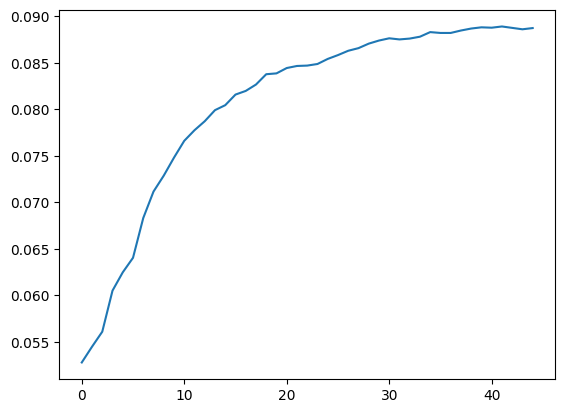

In [ ]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

## Save track embeddings

In [ ]:
biases, embeddings = model.get_item_representations()

In [ ]:
model.item_biases *= 0.0

In [ ]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [ ]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [ ]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [ ]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [ ]:
with open(DATA_DIR + "recommendations.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-100:]]
        recommendation = {
            "user": int(users[user_index]),
            "tracks": [int(x) for x in top]
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|██████████| 9985/9985 [00:55<00:00, 181.50it/s]
